In [1]:
import os
import numpy as np

import scipy.linalg 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from read_files import *
from my_interpolate import *


Bad key text.latex.preview in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an

All Functions

In [2]:
DATASET = 'HAND'

def get_centroids(points):
    """ obtain centroid of LV cardiac dataset which consists of two
    circles each containing 33 points """
    c1 = np.mean(points[:33],axis = 0)
    c2 = np.mean(points[33:],axis = 0) 
    return c1,c2

def unmake_1d(hand):
    return np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)])

def make_1d(hand):
    return np.concatenate((hand[:,0],hand[:,1])).reshape(-1)

def showImg(filename,show = False):
    plt.imshow(mpimg.imread(filename))
    plt.axis('off')
    if show:
        plt.show()

    
def showPoints(points,W=256,H=256, show = False,color = 'white'):
    points = np.array(points)
    plt.scatter(points[:,0]*W,points[:,1]*H,color=color,s = 1) 
    if show:
        plt.show()

def showSegImg(imgpath,points,W = None,H = None):
    if W is  None:
        W,H = getImageWH(imgpath)
    showImg(imgpath)
    if DATASET == 'HAND':
        pass
    else:

        showInterp(interp(points[:33]),W,H)
        showInterp(interp(points[33:]),W,H)
    showPoints(points,W,H,True)


def showCentroids(centroids,W=256,H=256):
    plt.scatter(centroids[:,0,0]*W,centroids[:,0,1]*H,marker = '4',color = 'black')
    plt.scatter(centroids[:,1,0]*W,centroids[:,1,1]*H,marker = '4',color = 'black')
    plt.axis('off')

def showPCAModes(mean_centre, mode ,title = None):
    mean_center_in = mean_centre.reshape(66,-1)[:33]
    mean_center_out = mean_centre.reshape(66,-1)[33:]

    ax1 = plt.subplot(1,2,1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in + mode.reshape(66,-1)[:33]),marker = 'b')
    showInterp(interp(mean_center_out + mode.reshape(66,-1)[:33]),marker = 'b')

    plt.subplot(1,2,2, sharex = ax1,sharey = ax1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in - mode.reshape(66,-1)[33:]),marker = 'g')
    showInterp(interp(mean_center_out - mode.reshape(66,-1)[33:]),marker = 'g')
    if title:
        plt.suptitle(title)
    
    plt.show()
    
def procrustes_hand(hands):
    np.testing.assert_equal(make_1d(unmake_1d(hands[0])),hands[0])
    normalized_hands = hands
    old_normalized_hands = hands
    
    #fig = plt.figure()
    #for hand in normalized_hands:
    #    showInterp(interp(unmake_1d(hand)))
    #plt.title('Before Procrustes Alignment')
    #plt.show()
    
    for count in range(5):
        mean_hand = np.mean(normalized_hands,axis = 0)
        for i,hand in enumerate(hands):
            _, mtx, disparity = scipy.spatial.procrustes(unmake_1d(mean_hand),
                                                         unmake_1d(hand))
            normalized_hands[i] = make_1d(mtx)

        
    #fig = plt.figure()
    #for hand in normalized_hands:
    #    showInterp(interp(unmake_1d(hand)))
    #plt.title('After Procrustes Alignment')
    #plt.show()
    
    return normalized_hands

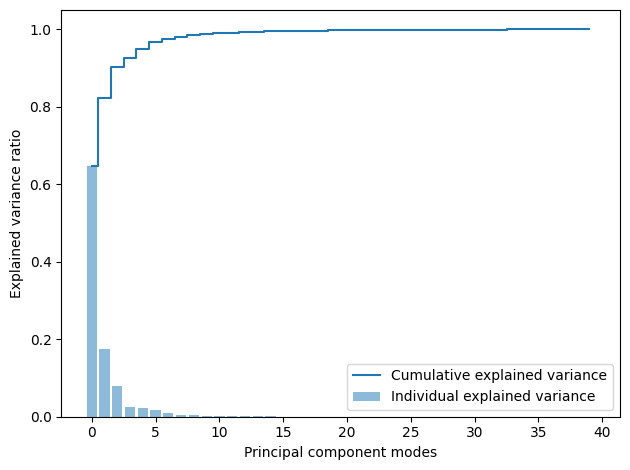

In [3]:
from sklearn.decomposition import PCA

filepath = './ssm_datasets/hand/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T

#showSegImg(os.path.join(filepath,'0000.jpg'),unmake_1d(hands[0]),600,600)

normalized_hands = procrustes_hand(hands)

pca = PCA(n_components=40)
pca.fit(normalized_hands)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component modes')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [4]:
Nb_points = normalized_hands.shape[1]
Nb_hands = normalized_hands.shape[0]

Mu = np.zeros(Nb_points)
Cov = np.zeros((Nb_points, Nb_points))

for i in range(Nb_points) :
    Mu[i] = np.average(normalized_hands[:, i])

for i in range(Nb_points) :
    for j in range(Nb_points) :
        for k in range(Nb_hands) :
            Cov[i, j] += (normalized_hands[k, i]-Mu[i])*(normalized_hands[k, j]-Mu[j])

Cov /= (Nb_hands-1)

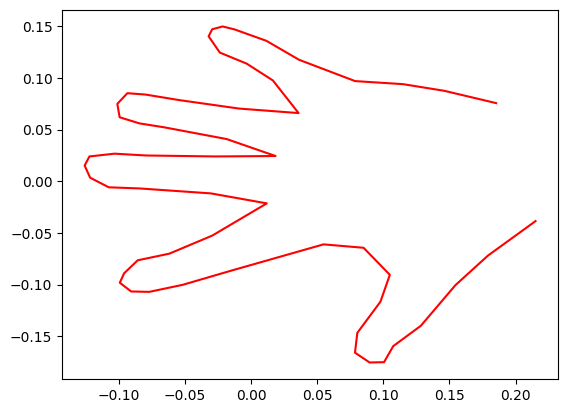

In [5]:
from copy import deepcopy
w, v = np.linalg.eig(Cov) 
w.shape, v.shape


P = 112
c = np.random.normal(0, 1, P)
Shape = deepcopy(Mu)
for i in range(P) :
    Shape += np.real(np.sqrt(np.absolute(w[i]))*c[i]*v[:, i])


S = unmake_1d(Shape)
plt.plot(S[:, 0], S[:, 1], c='r')
plt.show()

(40, 112)
(112, 112)


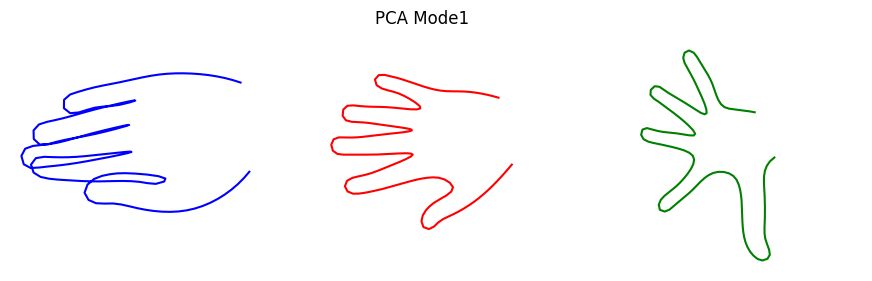

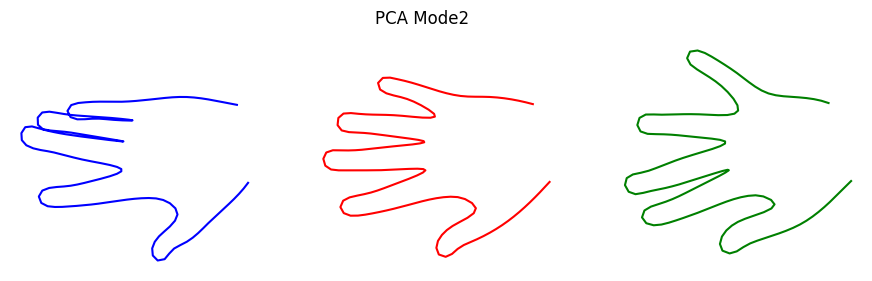

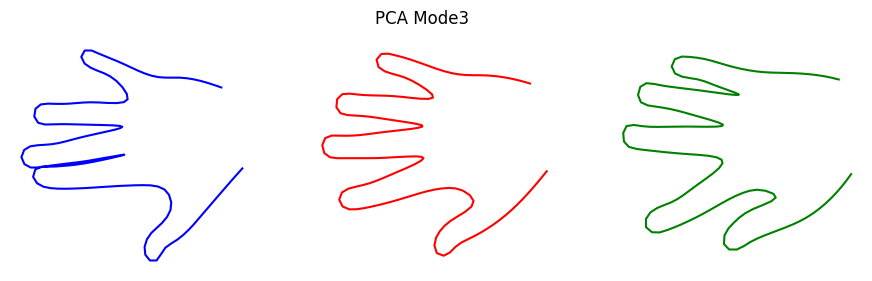

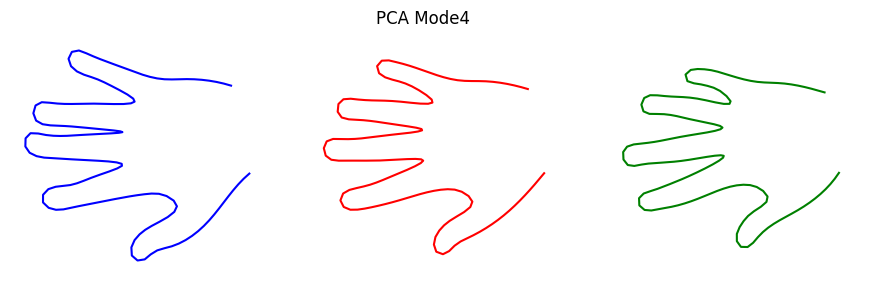

In [6]:
filepath = './ssm_datasets/hand/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T

print(hands.shape)
#showSegImg(os.path.join(filepath,'0000.jpg'),unmake_1d(hands[0]),600,600)

normalized_hands = procrustes_hand(hands)

mean_normalized_hand = np.mean(normalized_hands,axis = 0)
cov_mat = np.cov(normalized_hands.T)       
print(cov_mat.shape) 
eig_val, eig_vec = np.linalg.eigh(cov_mat)
m = unmake_1d(mean_normalized_hand)



for i in range(1,5):
    modeminus = unmake_1d(eig_vec[:,-i]*-3*np.sqrt(eig_val[-i]))+unmake_1d(mean_normalized_hand)
    modeplus = unmake_1d(eig_vec[:,-i]*3*np.sqrt(eig_val[-i]))+unmake_1d(mean_normalized_hand)
    fig = plt.figure(figsize =(11,3))
    ax1 = plt.subplot(131)
    showInterp(interp(modeminus),marker = 'b')   
    plt.subplot(132,sharex = ax1, sharey = ax1)
    showInterp(interp(m))
    plt.subplot(133,sharex = ax1, sharey = ax1)
    showInterp(interp(modeplus),marker = 'g')
    plt.suptitle('PCA Mode' + str(i))
plt.show()

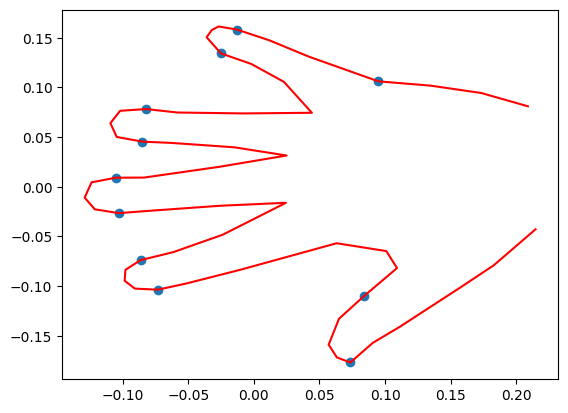

56


In [7]:
h = unmake_1d(normalized_hands[18]) 

N = len(h)

def spaced(idx, L, dist):
    for i in L :
        
        if abs(i-idx)<dist :
            return False
    return True

Control_pts = [5, 15, 25, 35, 45, 9, 19, 29, 39, 49, 52]
"""Control_pts = []
n = 10
for i in range(n) :
    idx = np.random.randint(0, N)
    while idx in Control_pts or not spaced(idx, Control_pts, 3) :
        idx = np.random.randint(0, N)
    Control_pts.append(idx)"""



plt.plot(h[:, 0], h[:, 1], c='r')

#showInterp(interp(h))
plt.scatter(h[Control_pts, 0], h[Control_pts, 1])
plt.show()
print(N)

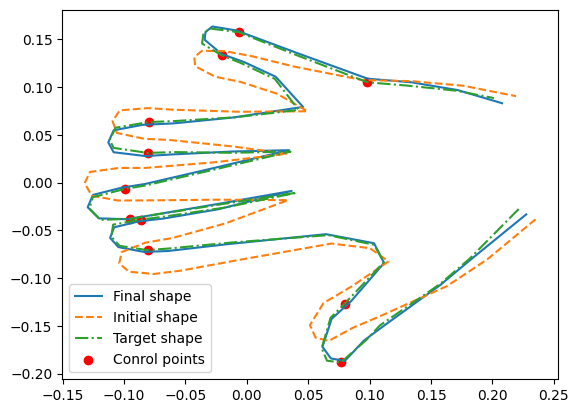

In [8]:
from copy import deepcopy
from IPython.display import clear_output


def loss(Control_pts, Model, target):
    l = 0
    for i in range(len(Control_pts)) :
        l += (Model[Control_pts[i]]- target[Control_pts[i]])**2 + (Model[Control_pts[i]+N]- target[Control_pts[i]+N])**2
    return l/len(Control_pts)

def deriv_loss(Model, Mean_shape):
    N = len(Model)//2
    A = np.vstack([Model[:N], Model[N:]]).T
    B = np.vstack([Mean_shape[:N], Mean_shape[N:]]).T
    dA = (np.roll(A, shift=-1, axis=0)-A)[:N-1]
    dB = (np.roll(B, shift=-1, axis=0)-B)[:N-1]
    """dB = []
    dA = []
    for i in range(N-1):
        dA.append(np.linalg.norm(A[i+1]-A[i]))
        dB.append(np.linalg.norm(B[i+1]-B[i]))"""
    return np.sum((np.linalg.norm(dA-dB, axis=1))**2)


def display(mean_normalized_hand, Actual_model, Target) :
    A = np.array(unmake_1d(Actual_model))
    B = np.array(unmake_1d(mean_normalized_hand))
    T = np.array(unmake_1d(Target)) 
    plt.plot(A[:, 0], A[:, 1], label='Final shape')
    plt.plot(B[:, 0], B[:, 1], linestyle='dashed', label='Initial shape')
    plt.plot(T[:, 0], T[:, 1], linestyle='dashdot', label='Target shape')
    plt.scatter(T[Control_pts, 0], T[Control_pts, 1], c='r', label='Conrol points')
    plt.legend()
    plt.show()

        


def Reconstruct(N_eig, N_iter, Id, R, disp):
    Target = normalized_hands[Id]
    Actual_model = deepcopy(mean_normalized_hand)
    for i in range(1, N_eig) :
        for _ in range(N_iter) :
            e = loss(Control_pts, Actual_model, Target) + R*deriv_loss(Actual_model, mean_normalized_hand)
            alpha = 4
            while loss(Control_pts, Actual_model+eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i]), Target)+R*deriv_loss(Actual_model+eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i]), mean_normalized_hand)>e :
                alpha *= 0.9
            Actual_model += eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i])
            e = loss(Control_pts, Actual_model, Target)+ R*deriv_loss(Actual_model, mean_normalized_hand)
            alpha = -4
            while loss(Control_pts, Actual_model+eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i]), Target)+R*deriv_loss(Actual_model+eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i]), mean_normalized_hand)>e :
                alpha *= 0.9
            Actual_model += eig_vec[:,-i]*alpha*np.sqrt(eig_val[-i])
            e = loss(Control_pts, Actual_model, Target)+ R*deriv_loss(Actual_model, mean_normalized_hand)
            
            if disp :
                display(mean_normalized_hand, Actual_model, Target)
                print('Mode : ', str(i))
                clear_output(wait=True)
    return Actual_model, Target

        
Actual_model, Target = Reconstruct(7, 20, 36, 0.001, True)
display(mean_normalized_hand, Actual_model, Target)

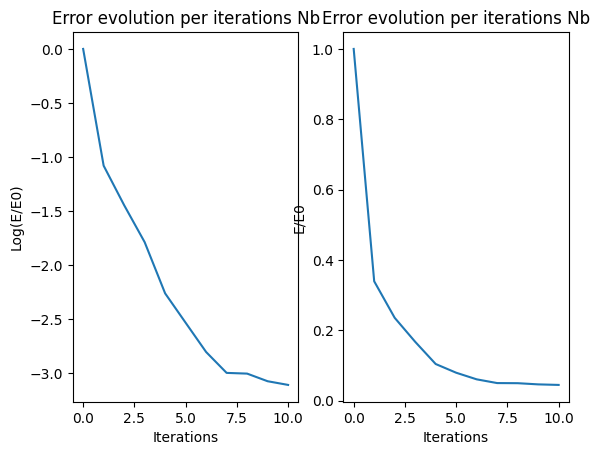

In [9]:
Error = [loss(Control_pts, mean_normalized_hand, Target)]
for j in range(1, 11) :
    Actual_model, Target = Reconstruct(7, j, 28, 0.01, False)
    Error.append(loss(Control_pts, Actual_model, Target)/Error[0])
    
Error[0]=1
Error = np.array(Error)

fig, ax = plt.subplots(1, 2)

ax[0].plot(range(0, 11), np.log(Error))
ax[0].set_title("Error evolution per iterations Nb")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Log(E/E0)")

ax[1].plot(range(0, 11), Error)
ax[1].set_title("Error evolution per iterations Nb")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("E/E0")

plt.show()

In [10]:
Xa = normalized_hands
m = Xa.shape[0]

X = (normalized_hands[:, :] - mean_normalized_hand).T
u, s, vh = np.linalg.svd(X, full_matrices=False)

print(u.shape, s.shape, vh.shape)

mi = []
M = []
for i in range(m) :

    Cp = np.sqrt(m)*np.diag(1/s) @ u.T @ (Xa[i] - mean_normalized_hand)
    mi.append(np.min(Cp))
    M.append(np.max(Cp))

# Rec_x = u @ np.diag(s) @ Cp/np.sqrt(m) + mean_normalized_hand

"""H = unmake_1d(Rec_x)
J = unmake_1d(Xa[i])
plt.plot(H[:, 0], H[:, 1])
plt.plot(J[:, 0], J[:, 1])
plt.show()"""

(112, 40) (40,) (40, 40)


'H = unmake_1d(Rec_x)\nJ = unmake_1d(Xa[i])\nplt.plot(H[:, 0], H[:, 1])\nplt.plot(J[:, 0], J[:, 1])\nplt.show()'

In [11]:
u.shape, s.shape

((112, 40), (40,))

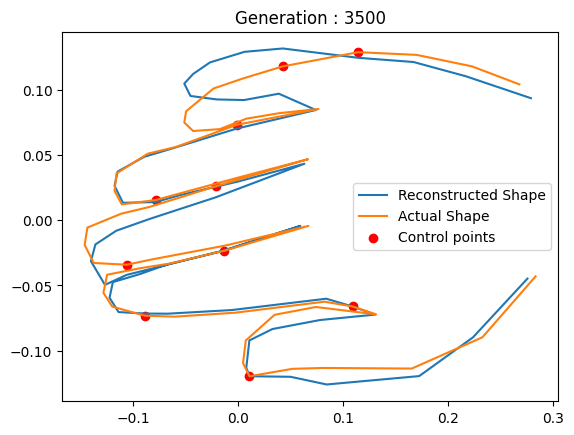

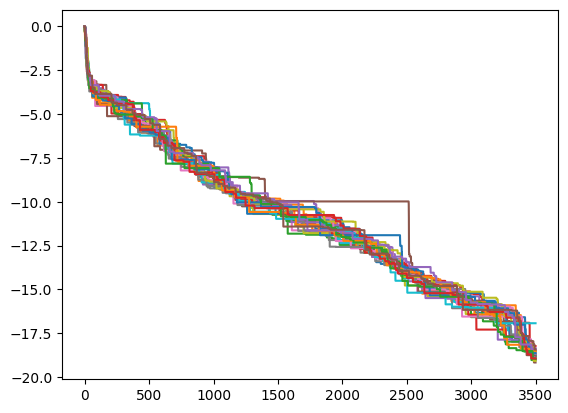

In [12]:
Target_Id = 35
Control_pts = [5, 15, 25, 35, 52, 11, 21, 31, 41, 51]

def rand_id(n, N):
    L = []
    for _ in range(3) :
        k = np.random.randint(0, N-1)
        while k==n :
            k = np.random.randint(0, N-1)
        L.append(k)
    return L

def loss(Control_pts, Model, target):
    l = 0
    for i in range(len(Control_pts)) :
        l += (Model[Control_pts[i]]- target[Control_pts[i]])**2 + (Model[Control_pts[i]+N]- target[Control_pts[i]+N])**2
    return l/len(Control_pts)

def deriv_loss(Model, Mean_shape):
    N = len(Model)//2
    A = np.vstack([Model[:N], Model[N:]]).T
    B = np.vstack([Mean_shape[:N], Mean_shape[N:]]).T
    dA = (np.roll(A, shift=-1, axis=0)-A)[:N-1]
    dB = (np.roll(B, shift=-1, axis=0)-B)[:N-1]
    return np.sum((np.linalg.norm(dA-dB, axis=1))**2)


def My_Cost(Cp):
    Model = u @ np.diag(s) @ Cp/np.sqrt(40) + mean_normalized_hand  ##PCA Projection
    #Model = u @ np.diag(s) @ u.T @ Cp + mean_normalized_hand
    Target = Xa[Target_Id]

    return loss(Control_pts, Model, Target) #+ 0*deriv_loss(Model, mean_normalized_hand)

def display(Cp, Id, g=2500) :

    X_rec = u @ np.diag(s) @ Cp/np.sqrt(40) + mean_normalized_hand
    #X_rec = u @ np.diag(s) @ u.T @ Cp + mean_normalized_hand

    H = unmake_1d(X_rec)
    J = unmake_1d(Xa[Id])
    plt.plot(H[:, 0], H[:, 1], label='Reconstructed Shape')
    plt.plot(J[:, 0], J[:, 1], label='Actual Shape')
    plt.scatter(J[Control_pts, 0], J[Control_pts, 1], c='r', label='Control points')
    plt.title("Generation : "+str(g))
    plt.legend()
    plt.show()


def DE_optim(Cost, N, D, G, m, M, F, C):
    P = np.random.normal(0, 0.1, (N, D))

    LOSS = np.ones((N, G))
    for g in range(G) :

        ## Mutation
        V = np.zeros((N, D))
        for n in range(N) :
            L = rand_id(n, N)
            V[n, :] = P[L[0], :] + F*(P[L[1], :] - P[L[2], :])

        ## Crossover
        U = np.zeros((N, D))
        for n in range(N) :
            I = np.random.randint(0, D-1)
            for k in range(D) :
                r = np.random.uniform(0, 1)
                if r<=C or k==I :
                    U[n, k] = V[n, k]
                else :
                    U[n, k] = P[n, k]
        
        ## Selection 
        for n in range(N) :
            for k in range(D):
                U[n, k] = max([m, min([M, U[n, k]])])
        for n in range(N) :
            if Cost(U[n, :])<Cost(P[n, :]) :
                P[n, :] = U[n, :]
            LOSS[n, g] = Cost(P[n, :])
        
        if not(g%100) :
            P_cost = np.zeros((N,1))
            for n in range(N):
                P_cost[n] = Cost(P[n, :])
            Indexes = np.argsort(P_cost)
            Best_gene = np.mean(P[Indexes[:6], :], axis=0)
            display(Best_gene[0], Target_Id, g)
            clear_output(wait=True)
    
    """Best_gene = P[0, :]
    for n in range(1, N) :
        if Cost(P[n, :])<Cost(Best_gene) :
            Best_gene = P[n, :]
    Best_gene = np.mean(P[np.random.randint, :], axis=0)"""

    P_cost = np.zeros((N,1))
    for n in range(N):
        P_cost[n] = Cost(P[n, :])
    Indexes = np.argsort(P_cost)
    Best_gene = np.mean(P[Indexes[:6], :], axis=0)
    
    return Best_gene, LOSS

D = 40
G = 3500
N = int(10+np.sqrt(D)+10)
m = -8
M = 8
F = 0.8
C = 0.6

Cp, Loss = DE_optim(My_Cost, N, D, G, m, M, F, C)
display(Cp[0], Target_Id, G)


for n in range(N) :       
    plt.plot(range(G), np.log(Loss[n, :]/Loss[n, 0]))
plt.show()

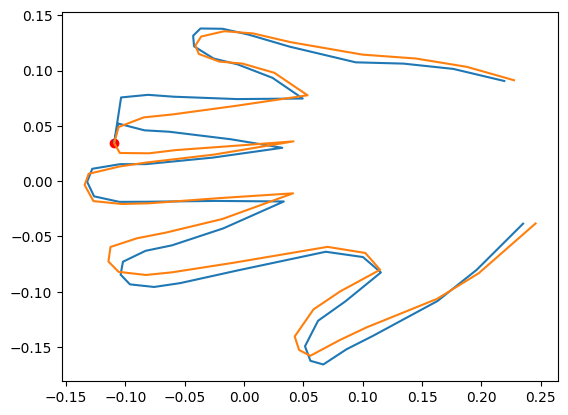

In [13]:
from copy import deepcopy

Init_shape = deepcopy(mean_normalized_hand)
Nb = len(Init_shape)//2
Ind = 37
Coords = [Ind, Ind+Nb]
Init_shape[Coords[0]] -= 0
Init_shape[Coords[1]] -= 0.03

H = unmake_1d(Init_shape)
plt.plot(H[:, 0], H[:, 1])

Copt = np.zeros(2)
Copt = np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)) @ (Init_shape[Coords]- mean_normalized_hand[Coords])

xrec = u @ np.diag(s) @ (u[Coords, :].T) @ Copt +mean_normalized_hand
H = unmake_1d(xrec)
plt.plot(H[:, 0], H[:, 1])
plt.scatter(Init_shape[Coords[0]], Init_shape[Coords[1]], c='r')
plt.show()


In [14]:
Nb = 112/2
#Control_pts = range(0, 20)
F = np.zeros(len(Control_pts)*2)

i = 0
while i < len(Control_pts) :
    F[2*i], F[2*i+1] = Control_pts[i], Control_pts[i]+Nb
    i += 1

F = F.astype(int)

In [15]:
len(Control_pts)

10

In [16]:
X_new = u[F, :] @ np.diag(s)
u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)

u_new.shape, s_new.shape, vh_new.shape

((20, 20), (20,), (20, 40))

In [17]:
X.shape, Xa.shape, F[2:2+2]

((112, 40), (40, 112), array([15, 71]))

In [18]:
np.max(X), np.max(Xa)

(0.0671642195275956, 0.2830637585352867)

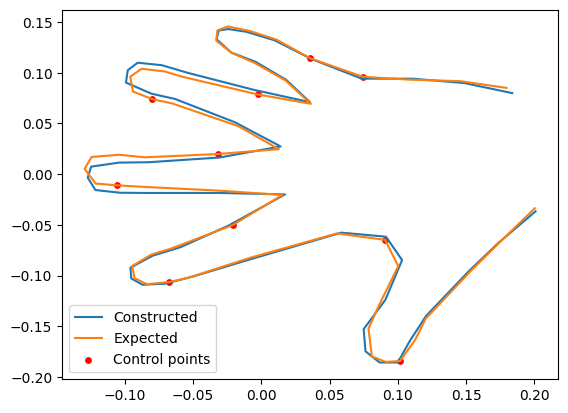

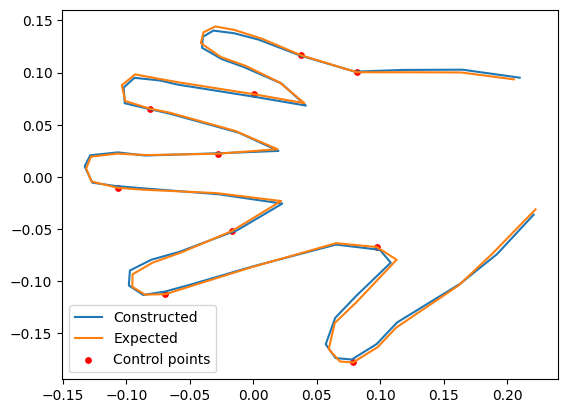

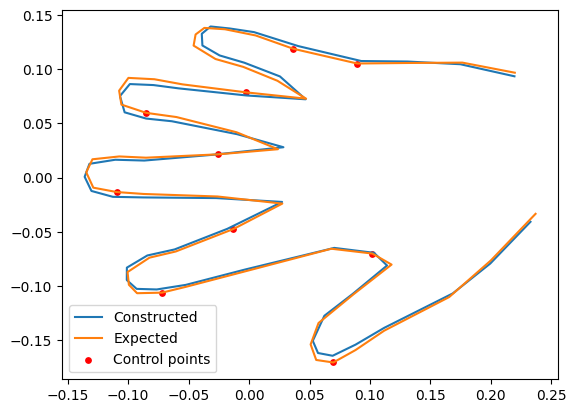

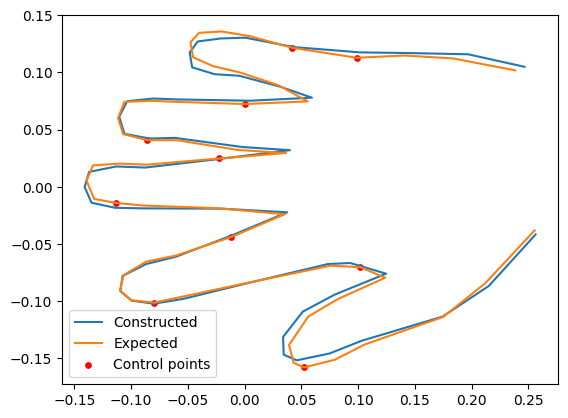

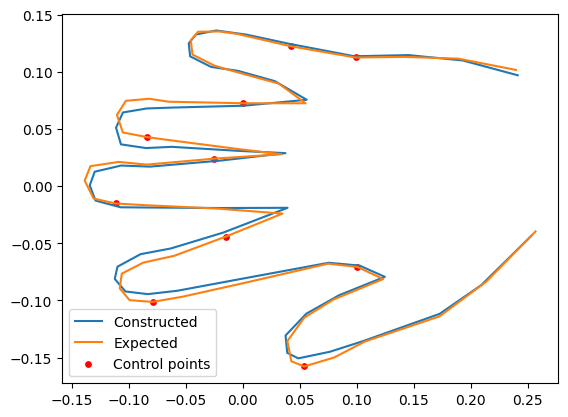

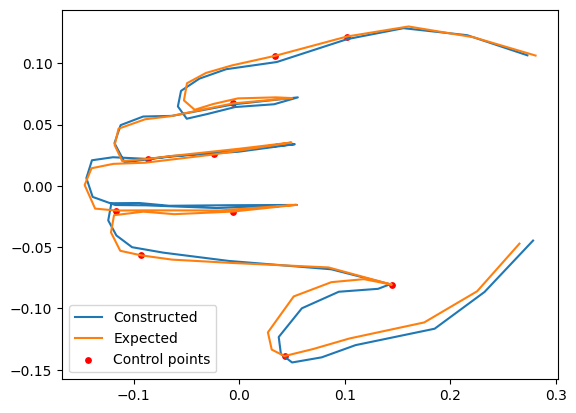

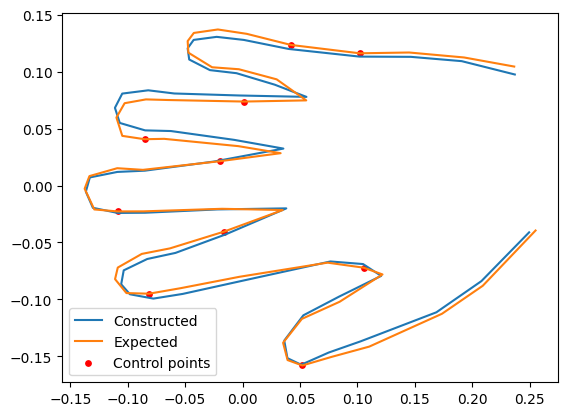

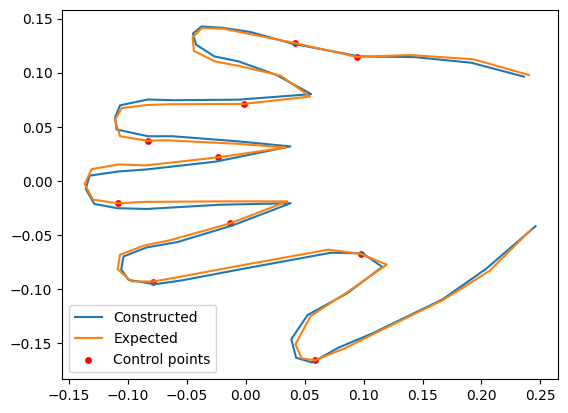

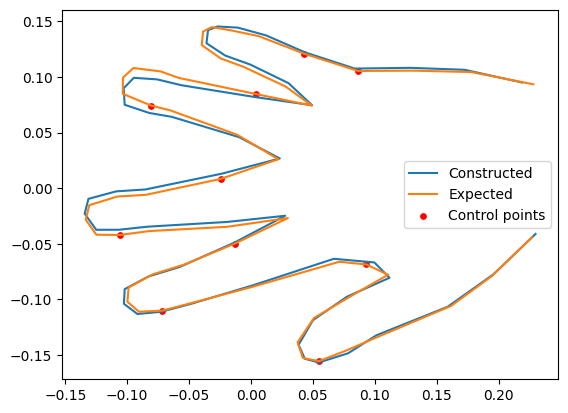

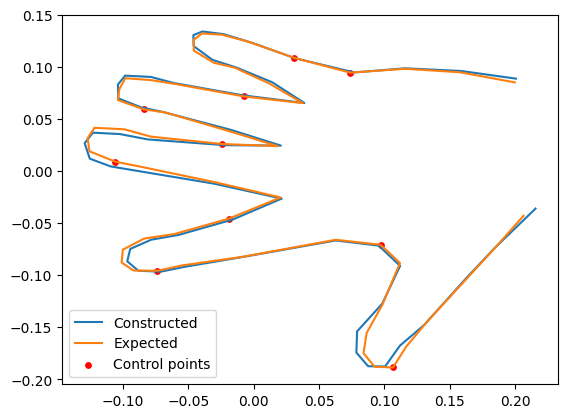

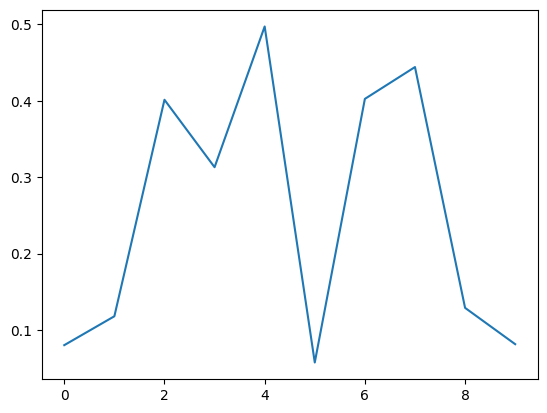

In [19]:
Xa = deepcopy(normalized_hands)
m = Xa.shape[0]

X = (normalized_hands[:, :] - mean_normalized_hand).T
u, s, vh = np.linalg.svd(X, full_matrices=False)


X_w = deepcopy(Xa)
Xa += np.random.normal(0, 0.003, Xa.shape)
X = (Xa - mean_normalized_hand).T

E = []
for i in range(10) :
    C_opt = vh_new.T @ np.diag(s_new/(s_new**2+0.001)) @ u_new.T @ X[F, i]
    Model = u @ np.diag(s) @ C_opt + mean_normalized_hand

    for j in range(len(Control_pts)) :
        Coords = F[2*j:2*j+2]
        Copt = np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)) @ (Xa[i][Coords]- Model[Coords])
        Model += u @ np.diag(s) @ (u[Coords, :].T) @ Copt 


    E.append((np.linalg.norm(Model-Xa[i])/np.linalg.norm(mean_normalized_hand-Xa[i]))**2)
    
    H = unmake_1d(Model)
    plt.plot(H[:, 0], H[:, 1], label='Constructed')
    H = unmake_1d(X_w[i])
    plt.plot(H[:, 0], H[:, 1], label='Expected')
    plt.scatter(H[Control_pts, 0], H[Control_pts, 1], label='Control points', c='r', s=15)
    plt.legend()
    plt.show()
    #break

plt.plot(E)
plt.show()

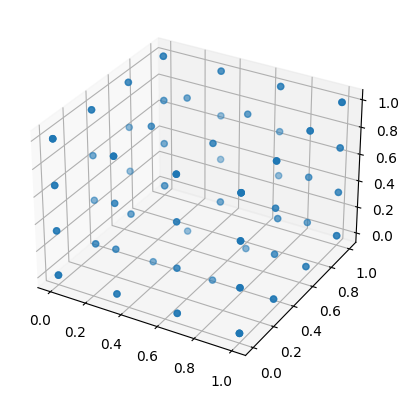

In [20]:
from sklearn.neighbors import NearestNeighbors

def Rectangle(w, l, pas, norm) :
    Vert = []
    X = np.linspace(0, w, int(w//pas))
    Y = np.linspace(0, l, int(l//pas))
    n, p = len(X), len(Y)
    if norm ==2 :
        for i in range(n) :
            for j in range(p) :
                Vert.append([X[i], Y[j], 0])
    elif norm==1 :
        for i in range(n) :
            for j in range(p) :
                Vert.append([X[i], 0, Y[j]])
    else :
        for i in range(n) :
            for j in range(p) :
                Vert.append([0, X[i], Y[j]])
    return np.array(Vert)


def Construct_mesh(h, w, l):
    S1 = Rectangle(w, l, 0.2, 2)
    S2 = deepcopy(S1)
    S2[:, 2] = h
    S3 = Rectangle(w, h, 0.2, 1)
    S4 = deepcopy(S3)
    S4[:, 1] = l
    S5 = Rectangle(l, h, 0.2, 0)
    S6 = deepcopy(S5)
    S6[:, 0] = w
    Vert = np.concatenate((S1, S2, S3, S4, S5, S6))
    return Vert

def display(Shape, ax) :
    nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(Shape)
    _, indices = nbrs.kneighbors(Shape)
    for i in range(len(Shape)) :
        for j in range(6):
            if indices[i, j] != i:
                print(i, j)
                ax.plot((Shape[i][0], Shape[indices[i, j]][0]), (Shape[i][1], Shape[indices[i, j]][1]), (Shape[i][2], Shape[indices[i, j]][2]))


R = Construct_mesh(1, 1, 1)
R = np.unique(R, axis=1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(R[:, 0], R[:, 1], R[:, 2])
plt.show()

In [21]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def Construct_Rect(h, w, l) :
    points = np.array([[-1, -1, -1],
                    [1, -1, -1 ],
                    [1, 1, -1],
                    [-1, 1, -1],
                    [-1, -1, 1],
                    [1, -1, 1 ],
                    [1, 1, 1],
                    [-1, 1, 1]])
    points = points.astype(float)
    points[:, 0] *= l/2
    points[:, 1] *= w/2
    points[:, 2] *= h/2
    points[:, 0] += l/2
    points[:, 1] += w/2
    points[:, 2] += h/2
    return points

def display(Z):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    verts = [[Z[0],Z[1],Z[2],Z[3]],
    [Z[4],Z[5],Z[6],Z[7]],
    [Z[0],Z[1],Z[5],Z[4]],
    [Z[2],Z[3],Z[7],Z[6]],
    [Z[1],Z[2],Z[6],Z[5]],
    [Z[4],Z[7],Z[3],Z[0]]]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.20))
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2], c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    

Z= Construct_Rect(1.6, 3.1, 1)
display(Z)
#plt.show()

1e-06
0.1001010990990991
0.2002011981981982
0.30030129729729726
0.4004013963963964
0.5005014954954955
0.6006015945945946
0.7007016936936937
0.8008017927927928
0.900901891891892
1.0010019909909909
1.10110209009009
1.201202189189189
1.3013022882882883
1.4014023873873873
1.5015024864864865
1.6016025855855855
1.7017026846846846
1.8018027837837838
1.9019028828828828
2.002002981981982
2.1021030810810815
2.2022031801801805
2.3023032792792795
2.4024033783783785
2.5025034774774775
2.602603576576577
2.702703675675676
2.802803774774775
2.902903873873874
3.0030039729729734
3.1031040720720724
3.2032041711711714
3.3033042702702704
3.4034043693693694
3.503504468468469
3.603604567567568
3.703704666666667
3.803804765765766
3.9039048648648653
4.004004963963964
4.104105063063063
4.204205162162163
4.304305261261262
4.404405360360361
4.50450545945946
4.604605558558559
4.704705657657658
4.804805756756757
4.904905855855856
5.005005954954955
5.105106054054055
5.205206153153154
5.305306252252253
5.405406351351

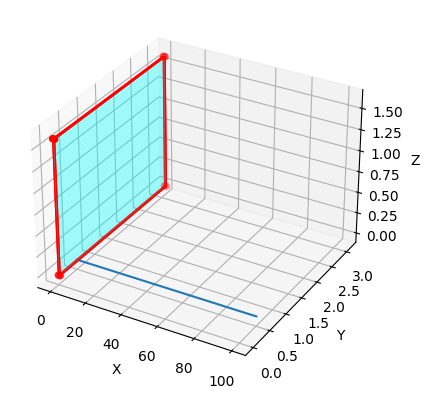

In [23]:
Shapes_Population = []
N = 50

for i in range(N) :
    w, l, h = np.random.uniform(0.1, 10, 3)
    Z= Construct_Rect(h, w, l) 
    Shapes_Population.append(Z)
    
Data = np.zeros((N, 3*Shapes_Population[0].shape[0]))
for i in range(N) :
    Data[i, :] = np.concatenate((Shapes_Population[i][:, 0], Shapes_Population[i][:, 1], Shapes_Population[i][:, 2]))



Control_pts = [0, 2, 5]
i = 0
F = np.zeros(len(Control_pts)*3)
while i < len(Control_pts) :
    F[3*i], F[3*i+1], F[3*i+2]= Control_pts[i], Control_pts[i]+8, Control_pts[i]+16
    i += 1
F = F.astype(int)

## Processing 
Xa = deepcopy(Data)

mean_shape = np.mean(Data, axis=0)
m = Xa.shape[0]
X = (Xa - mean_shape).T

u, s, vh = np.linalg.svd(X, full_matrices=False)

X_new = u[F, :] @ np.diag(s)
u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)

u_new.shape, s_new.shape, vh_new.shape

Xw = deepcopy(Xa)
Xa += np.random.normal(0, 0.2, Xa.shape)
X = (Xa - mean_shape).T


Eta = np.linspace(0.000001, 100, 1000)
Error = []
for e in Eta:
    print(e)
    E = []
    for i in range(40) :
        C_opt = vh_new.T @ np.diag(s_new/(s_new**2+e)) @ u_new.T @ X[F, i]
        Model = u @ np.diag(s) @ C_opt + mean_shape

        for j in range(len(Control_pts)) :
            Coords = F[3*j:3*j+3]
            Copt = np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)) @ (Xa[i][Coords]- Model[Coords])
            Model += u @ np.diag(s) @ (u[Coords, :].T) @ Copt 
        
        E.append((np.linalg.norm(Model-Xw[i])/np.linalg.norm(mean_shape-Xw[i]))**2)
    Error.append(np.mean(np.array(E)))


plt.plot(Eta, Error)
plt.show()